In [1]:
# import libraries  
import argparse
from collections import Counter, defaultdict
import cv2
from PIL import Image
import glob
import geopy
from geopy.distance import distance
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import pandas as pd
import pickle
import tqdm
import rasterio
import shapely
from shapely.geometry import Point, Polygon
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage import transform as sktransform
import math
import random
from statistics import mean

# Neural Combinatorial Optimization using Graph Neural Network

## Graphic Visualisation of Processes (Phase 1 and 2 of the Experiments)

In [4]:
problem = "pdptw" # Add the problem solved (either cvrp, cvrptw, pdp or pdptw)

n_nodes = "200" # Add the number of nodes specified for each problem

NLKH_log_folder = problem + "_" + n_nodes + "/NeuroLKH_log/*.log"
LKH_log_folder = problem + "_" + n_nodes + "/LKH_log/*.log"

neuro_log_file = glob.glob(NLKH_log_folder)
lkh_log_file = glob.glob(LKH_log_folder)

Here, we try to extract, for process documentation, the objective function, the penalty and the time values per instance per LKH trial

In [5]:
#NeuroLKH metrics

m_nlkh_obj = np.zeros((1000,1000))   
m_nlkh_pen = np.zeros((1000,1000))
m_nlkh_time = np.zeros((1000,1000))

#LKH metrics

m_lkh_obj = np.zeros((1000,1000))
m_lkh_pen = np.zeros((1000,1000))
m_lkh_time = np.zeros((1000,1000))


for i in range(len(neuro_log_file)):
    with open(neuro_log_file[i], 'r') as f:
        neuro_log_data = f.readlines()
    line_ = []
    for line in neuro_log_data:
        line = line.split()
        line_.append(line)

    while([] in line_):
        line_.remove([])
    nlkh_obj = []
    nlkh_pen = []
    nlkh_time = []
    for j in range(len(line_)):
        if line_[j][0] == '-Trial':
            m_nlkh_obj_ = int(float(line_[j][3]))
            nlkh_obj.append(m_nlkh_obj_)
            m_nlkh_pen_ = int(float(line_[j][2]))
            nlkh_pen.append(m_nlkh_pen_)
            m_nlkh_time_ = float(line_[j][4])
            nlkh_time.append(m_nlkh_time_)
        
    m_nlkh_obj[i] = nlkh_obj
    m_nlkh_pen[i] = nlkh_pen
    m_nlkh_time[i] = nlkh_time


for i in range(len(lkh_log_file)):
    with open(lkh_log_file[i], 'r') as f:
        lkh_log_data = f.readlines()
    line_ = []
    for line in lkh_log_data:
        line = line.split()
        line_.append(line)

    while([] in line_):
        line_.remove([])
    lkh_obj = []
    lkh_pen = []
    lkh_time = []
    for j in range(len(line_)):
        if line_[j][0] == '-Trial':
            m_lkh_obj_ = int(float(line_[j][3]))
            lkh_obj.append(m_lkh_obj_)
            m_lkh_pen_ = int(float(line_[j][2]))
            lkh_pen.append(m_lkh_pen_)
            m_lkh_time_ = float(line_[j][4])
            lkh_time.append(m_lkh_time_)
            
    m_lkh_obj[i] = lkh_obj
    m_lkh_pen[i] = lkh_pen
    m_lkh_time[i] = lkh_time    

All these quantities are then averaged over 1000 instances

In [6]:
mean_m_nlkh_obj = m_nlkh_obj.mean(axis=0)
mean_m_nlkh_pen = m_nlkh_pen.mean(axis=0)
mean_m_nlkh_time = m_nlkh_time.mean(axis=0)
mean_m_lkh_obj = m_lkh_obj.mean(axis=0)
mean_m_lkh_pen = m_lkh_pen.mean(axis=0)
mean_m_lkh_time = m_lkh_time.mean(axis=0)

# Here we obtain the sum over 1000 instances of the solving time

mean_n_nlkh_time = m_nlkh_time.sum(axis=0)
mean_n_lkh_time = m_lkh_time.sum(axis=0)


## Plots

### Average Comparative Performance 

<function matplotlib.pyplot.show(close=None, block=None)>

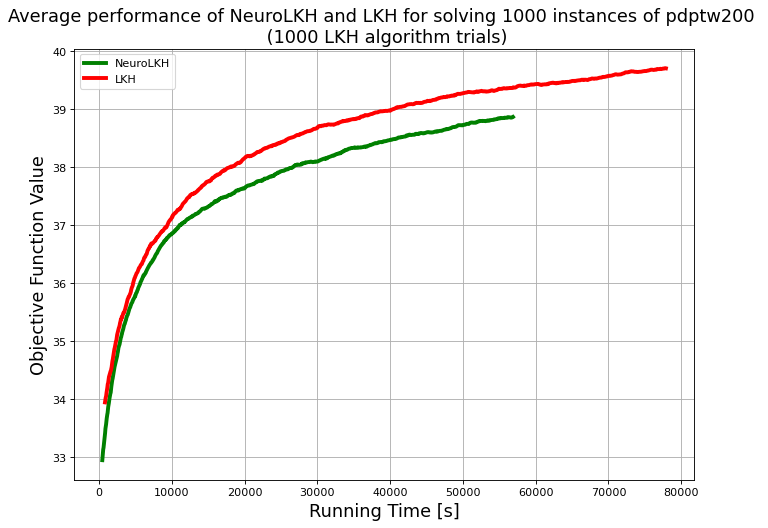

In [7]:
plt.figure(figsize=(10, 7), dpi=80)

plt.plot(mean_n_nlkh_time,mean_m_nlkh_obj*10e-7,lw=3.5,color='g',label = 'NeuroLKH')
plt.plot(mean_n_lkh_time,mean_m_lkh_obj*10e-7,lw=3.5,color='r',label = 'LKH')

# 
plt.xlabel('Running Time [s]',fontsize = '16')
plt.ylabel('Objective Function Value',fontsize = '16')
plt.title('Average performance of NeuroLKH and LKH for solving 1000 instances of ' + problem + n_nodes +' \n (1000 LKH algorithm trials)',fontsize='16')
plt.legend()
plt.grid(True)
plt.show
#plt.savefig(problem+'_'+n_nodes+^'_perf.png')

### Average Comparative Penalties 

<function matplotlib.pyplot.show(close=None, block=None)>

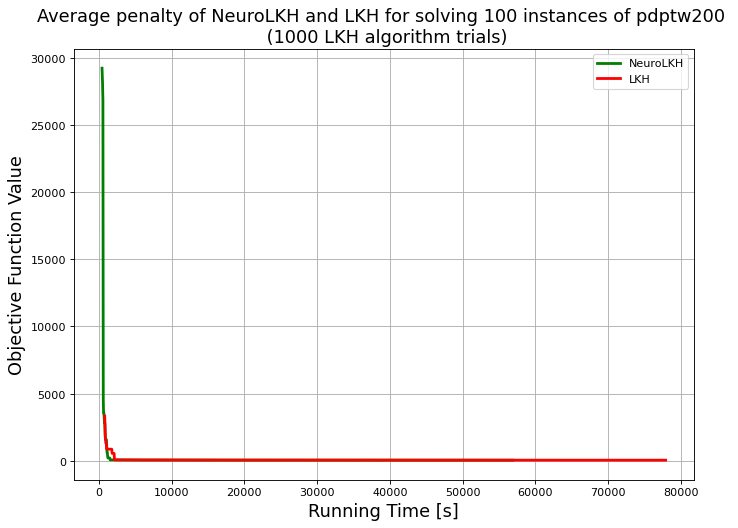

In [10]:
plt.figure(figsize=(10, 7), dpi=80)

plt.plot(mean_n_nlkh_time,mean_m_nlkh_pen,lw=2.5,color='g',label = 'NeuroLKH')
plt.plot(mean_n_lkh_time,mean_m_lkh_pen,lw=2.5,color='r',label = 'LKH')

# 
plt.xlabel('Running Time [s]',fontsize = '16')
plt.ylabel('Objective Function Value',fontsize = '16')
plt.title('Average penalty of NeuroLKH and LKH for solving 100 instances of ' + problem + n_nodes +' \n (1000 LKH algorithm trials)',fontsize='16')
plt.legend()
plt.grid(True)
plt.show
#plt.savefig('PDP500_penalty.png')

## Comparative of two problems (PDPTW200 vs CVRPTW500)

Here, we display the script to obtain the three variables Rinc, Rdec and delta_obj that helps us quantify the impact of the penalty value, on average, over a process and the efficiency of the local search algorithm.

We have to run the following code for each of both problems. Hereafter, the results for PDPTW200 are displayed.

First, we obtain the penalty vectors for each instance where the values are non-zero. Indeed, we want to highlight the effect of the penalty on the minimization of the cost

In [20]:
clean_nlkh_pen = []
clean_nlkh_obj = []

for i in range(len(m_nlkh_pen)):
    if (m_nlkh_pen[i][0]!= 0):
        
        clean_nlkh_pen_ = m_nlkh_pen[i]
        clean_nlkh_pen.append(clean_nlkh_pen_)
        clean_nlkh_obj_ = m_nlkh_obj[i]
        clean_nlkh_obj.append(clean_nlkh_obj_)
clean_lkh_pen = []
clean_lkh_obj = []

for i in range(len(m_lkh_pen)):
    if (m_lkh_pen[i][0]!= 0):
        
        clean_lkh_pen_ = m_lkh_pen[i]
        clean_lkh_pen.append(clean_lkh_pen_)
        clean_lkh_obj_ = m_lkh_obj[i]
        clean_lkh_obj.append(clean_lkh_obj_)
        
clean_nlkh_pen = np.array(clean_nlkh_pen)
clean_nlkh_obj = np.array(clean_nlkh_obj)
clean_lkh_pen = np.array(clean_lkh_pen)
clean_lkh_obj = np.array(clean_lkh_obj)


Here, the three metrics are initialized and obtained

In [21]:
#NeuroLKH Results

all_obj_ratio_nlkh = []
all_comp_obj_nlkh = []
all_diff_obj_nlkh = []


for sample in range(len(clean_nlkh_pen)):
    pdptw_nlkh_sample_obj = clean_nlkh_obj[sample]
    pdptw_nlkh_sample_pen = clean_nlkh_pen[sample]
   
    obj_diff_nlkh = np.zeros([len(pdptw_nlkh_sample_pen)])
    obj_ratio_nlkh = np.zeros([len(pdptw_nlkh_sample_pen)])
    
    for i in range(len(pdptw_nlkh_sample_pen)-1):
        if (pdptw_nlkh_sample_pen[i+1] != 0):
            if (pdptw_nlkh_sample_pen[i+1] < pdptw_nlkh_sample_pen[i]):
                obj_diff_nlkh[i+1] = pdptw_nlkh_sample_obj[i+1] - pdptw_nlkh_sample_obj[i]
                obj_ratio_nlkh[i+1] = 100*(pdptw_nlkh_sample_obj[i+1] - pdptw_nlkh_sample_obj[i])/pdptw_nlkh_sample_obj[i]
        
    mod_idx_nlkh = []        
    for i in range(len(obj_diff_nlkh)-1):
        if (obj_diff_nlkh[i+1] != 0) :
            mod_idx_nlkh.append(i+1)
            

                
    comp_obj_nlkh = []
    diff_obj_nlkh = []
    if (len(mod_idx_nlkh) > 1) :
        for i in range(len(mod_idx_nlkh)-1):
            comp_obj_nlkh_ = 100*(pdptw_nlkh_sample_obj[mod_idx_nlkh[i+1]-1] - pdptw_nlkh_sample_obj[mod_idx_nlkh[i]])/pdptw_nlkh_sample_obj[mod_idx_nlkh[i+1]-1] #rate of decrease
            comp_obj_nlkh.append(comp_obj_nlkh_)
            diff_obj_nlkh_ = pdptw_nlkh_sample_obj[mod_idx_nlkh[i+1]-1] - pdptw_nlkh_sample_obj[mod_idx_nlkh[i]-1]  # diff of decrease
            diff_obj_nlkh.append(diff_obj_nlkh_)
            
        all_obj_ratio_nlkh_= [obj_ratio_nlkh.max(), obj_ratio_nlkh[obj_ratio_nlkh > 0].mean(), obj_ratio_nlkh.min()]
        all_obj_ratio_nlkh.append(all_obj_ratio_nlkh_)
        
        all_comp_obj_nlkh_ = [max(comp_obj_nlkh),mean(comp_obj_nlkh), min(comp_obj_nlkh)]
        all_comp_obj_nlkh.append(all_comp_obj_nlkh_)
        
        all_diff_obj_nlkh_ = mean(diff_obj_nlkh)
        all_diff_obj_nlkh.append(all_diff_obj_nlkh_)
    
    else :
        sample = sample + 1
        
    
    
    
    
    
    
    
    


In [22]:
#LKH Results

all_obj_ratio_lkh = []
all_comp_obj_lkh = []
all_diff_obj_lkh = []


for sample in range(len(clean_lkh_pen)):
    pdptw_lkh_sample_obj = clean_lkh_obj[sample]
    pdptw_lkh_sample_pen = clean_lkh_pen[sample]
   
    obj_diff_lkh = np.zeros([len(pdptw_lkh_sample_pen)])
    obj_ratio_lkh = np.zeros([len(pdptw_lkh_sample_pen)])
    
    for i in range(len(pdptw_lkh_sample_pen)-1):
        if (pdptw_lkh_sample_pen[i+1] != 0):
            if (pdptw_lkh_sample_pen[i+1] < pdptw_lkh_sample_pen[i]):
                obj_diff_lkh[i+1] = pdptw_lkh_sample_obj[i+1] - pdptw_lkh_sample_obj[i]
                obj_ratio_lkh[i+1] = 100*(pdptw_lkh_sample_obj[i+1] - pdptw_lkh_sample_obj[i])/pdptw_lkh_sample_obj[i]
       
        
    mod_idx_lkh = []        
    for i in range(len(obj_diff_lkh)-1):
        if (obj_diff_lkh[i+1] != 0) :
            mod_idx_lkh.append(i+1)
            

                
    comp_obj_lkh = []
    diff_obj_lkh = []
    if (len(mod_idx_lkh) > 1) :
        for i in range(len(mod_idx_lkh)-1):
            comp_obj_lkh_ = 100*(pdptw_lkh_sample_obj[mod_idx_lkh[i+1]-1] - pdptw_lkh_sample_obj[mod_idx_lkh[i]])/pdptw_lkh_sample_obj[mod_idx_lkh[i+1]-1]
            comp_obj_lkh.append(comp_obj_lkh_)
            diff_obj_lkh_ = pdptw_lkh_sample_obj[mod_idx_lkh[i+1]-1] - pdptw_lkh_sample_obj[mod_idx_lkh[i]-1]
            diff_obj_lkh.append(diff_obj_lkh_)
            
        all_obj_ratio_lkh_= [obj_ratio_lkh.max(), obj_ratio_lkh[obj_ratio_lkh > 0].mean(), obj_ratio_lkh.min()]
        all_obj_ratio_lkh.append(all_obj_ratio_lkh_)
        
        all_comp_obj_lkh_ = [max(comp_obj_lkh),mean(comp_obj_lkh), min(comp_obj_lkh)]
        all_comp_obj_lkh.append(all_comp_obj_lkh_)
        
        all_diff_obj_lkh_ = mean(diff_obj_lkh)
        all_diff_obj_lkh.append(all_diff_obj_lkh_)
    
    else :
        sample = sample + 1
        

In [23]:
all_obj_ratio_nlkh = np.array(all_obj_ratio_nlkh)
all_obj_ratio_lkh = np.array(all_obj_ratio_lkh)
all_comp_obj_nlkh = np.array(all_comp_obj_nlkh)
all_comp_obj_lkh = np.array(all_comp_obj_lkh)
all_diff_obj_nlkh = np.array(all_diff_obj_nlkh)
all_diff_obj_lkh = np.array(all_diff_obj_lkh)


In [24]:
all_obj_ratio_nlkh = all_obj_ratio_nlkh[~np.isnan(all_obj_ratio_nlkh).any(axis=1), :]
all_obj_ratio_lkh = all_obj_ratio_lkh[~np.isnan(all_obj_ratio_lkh).any(axis=1), :]


In [27]:

all_mean_obj_ratio_nlkh = [all_obj_ratio_nlkh[:,0].mean(), all_obj_ratio_nlkh[:,1].mean(),all_obj_ratio_nlkh[:,2].mean()]  
print("Relative Difference R_inc - NeuroLKH :")
print(all_mean_obj_ratio_nlkh)
all_mean_obj_ratio_lkh = [all_obj_ratio_lkh[:,0].mean(), all_obj_ratio_lkh[:,1].mean(),all_obj_ratio_lkh[:,2].mean()]
print("Relative Difference R_inc - LKH :")
print(all_mean_obj_ratio_lkh)



Relative Difference R_inc - NeuroLKH :
[6.285880689696914, 2.1826282634964382, -1.926456597964312]
Relative Difference R_inc - LKH :
[6.480163674548089, 2.223236451263521, -2.218389323646107]


In [28]:
all_mean_comp_obj_nlkh = [all_comp_obj_nlkh[:,0].mean(), all_comp_obj_nlkh[:,1].mean(),all_comp_obj_nlkh[:,2].mean()]
print("Relative Difference R_dec - NeuroLKH :")
print(all_mean_comp_obj_nlkh)
all_mean_comp_obj_lkh = [all_comp_obj_lkh[:,0].mean(), all_comp_obj_lkh[:,1].mean(),all_comp_obj_lkh[:,2].mean()]
print("Relative Difference R_dec - LKH :")
print(all_mean_comp_obj_lkh)


Relative Difference R_dec - NeuroLKH :
[0.0, -0.9483642371013603, -5.057597376261562]
Relative Difference R_dec - LKH :
[0.0, -1.026823446777351, -5.53887875673446]


In [30]:
print("Average Difference delta_obj - NeuroLKH :")
print(all_diff_obj_nlkh.mean())

print("Average Difference delta_obj - LKH :")
print(all_diff_obj_lkh.mean())



Average Difference delta_obj - NeuroLKH :
257076.6474349588
Average Difference delta_obj - LKH :
230591.4326522948
